In [78]:
#standard imports
import pandas as pd
import numpy as np
import seaborn as sns 

# to be able to count genres since movies may fall under several genres
from sklearn.feature_extraction.text import CountVectorizer

# to connect plotly with pandas
import cufflinks as cf  
import plotly           # to plot interactive visualizations
import chart_studio.plotly as py  #more charting options 
import plotly.express as px
%matplotlib inline


#to run plotly offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot   
init_notebook_mode(connected=True)
cf.go_offline()

## TASK OUTLINE: 
1. Read in IMDB, Movielens, Rotten Tomatoes, TMDB data, and only have useful columns for EDA *done
2. Make sure each df has ratings, remove Nulls *done
3. Normalize scores *done
4. Create an aggregate score by getting the mean of the normalized scores *done
5. Read in Oscar data, add win, loss and nomination data to master DF *done
6. EDA and Plot charts based on  *done- mostly with stat stuff pending
7. Based on success criteria 1 (revenue > 2x budget) create flag of 1 or 0 in master DF - b_success (boxofficee success)
8. Based on success criteria 2 (score >= 7 ) create flag of 1 or 0 in master DF - r_success (review success)
9. Based on success criteria 3 (oscar nod) create flag of 1 or 0 in master DF - c_success (critic success)

Hypotheis test:
  - Null: Good movies do well in the box office 
  - Alternate: Good movies do not do well in the box office most of the time
  
Methodology:
  - use the kickboard example in lecture? if r_success, is it b_success? c_success? 
      - compound probability? p(rating > 7) and p(Revenue > 2x Budget)?
      - compound probability? p(oscar nod > 0) and p(Revenue > 2x Budget)?
  - Correlation tests? ROI vs score
  - eyeball charts based on data?
  






### QUESTIONS:
1. does the normalization make sense? Should I just take the mean of the 4 ratings instead?
2. presenation : slide + browser? animated gif ? streamllit? python charts or display data with 3rd party charts?
3. 2663/5000 rows that satisfy "box office success" criteria, is that enough?


In [558]:
## Read data 

def read_data(path, filename, sep='None', header=0):
    fullpath = path+filename
    #print(fullpath)
    temp_df = pd.read_csv(fullpath, sep=sep, header=header, low_memory=False)
    return temp_df

#testing = read_data('data/','title_basics.tsv', sep='\t',header=0)

### Read in IMDB Data

In [559]:
# IMDB movie and rating data
df_imdb_titles = pd.read_csv('data/title_basics.tsv', sep='\t', header=0, low_memory=False)
df_imdb_ratings = pd.read_csv('data/title_ratings.tsv', sep='\t', header=0, low_memory=False)

# combining 2 dataframes to get ratings into title data
df_imdb = pd.merge(df_imdb_titles,df_imdb_ratings,how='left',on='tconst') 


# grabbing only movies from IMDB data
df_imdb = df_imdb[df_imdb['titleType']=='movie'] 


#subset to get only relevant columns
df_imdb = df_imdb[['tconst','primaryTitle','originalTitle','startYear','runtimeMinutes','genres','averageRating','numVotes']]

In [560]:
df_imdb.isna().sum()

tconst                 0
primaryTitle           0
originalTitle          0
startYear              0
runtimeMinutes         0
genres                 0
averageRating     315727
numVotes          315727
dtype: int64

In [561]:

df_imdb = df_imdb.replace(r"\N", np.nan) 

# subset only for movies with genre 

df_imdb = df_imdb[df_imdb['genres'].notna()]
df_imdb = df_imdb[df_imdb['averageRating'].notna()]
df_imdb = df_imdb[df_imdb['startYear'].notna()]
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255072 entries, 570 to 8033868
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          255072 non-null  object 
 1   primaryTitle    255072 non-null  object 
 2   originalTitle   255072 non-null  object 
 3   startYear       255072 non-null  object 
 4   runtimeMinutes  232414 non-null  object 
 5   genres          255072 non-null  object 
 6   averageRating   255072 non-null  float64
 7   numVotes        255072 non-null  float64
dtypes: float64(2), object(6)
memory usage: 17.5+ MB


In [562]:
df_imdb.isna().sum()

tconst                0
primaryTitle          0
originalTitle         0
startYear             0
runtimeMinutes    22658
genres                0
averageRating         0
numVotes              0
dtype: int64

In [563]:
df_imdb.columns

Index(['tconst', 'primaryTitle', 'originalTitle', 'startYear',
       'runtimeMinutes', 'genres', 'averageRating', 'numVotes'],
      dtype='object')

## Rename columns then export csv

In [564]:
#df_imdb = df_imdb[['primaryTitle','startYear','genres','averageRating','originalTitle','tconst']].sort_values(by="startYear", ascending=False)
df_imdb = df_imdb.rename(columns={'genres': 'Genres'})
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255072 entries, 570 to 8033868
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          255072 non-null  object 
 1   primaryTitle    255072 non-null  object 
 2   originalTitle   255072 non-null  object 
 3   startYear       255072 non-null  object 
 4   runtimeMinutes  232414 non-null  object 
 5   Genres          255072 non-null  object 
 6   averageRating   255072 non-null  float64
 7   numVotes        255072 non-null  float64
dtypes: float64(2), object(6)
memory usage: 17.5+ MB


In [565]:
# export data to csv
df_imdb.to_csv (r'data//IMDB_main.csv', index = False, header=True)

-------------------------------------
### Read in Box Office Mojo Data

In [566]:
df_box = pd.read_csv('data/boxoffice/movies_metadata.csv', low_memory=False)

In [567]:
df_box.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [568]:
# Subset to remove rows without imdb_id or vote_average
df_box = df_box[df_box['imdb_id'].notna()]
df_box = df_box[df_box['vote_average'].notna()]
df_box = df_box[['title',
                 'original_title',
                 'revenue',
                 'budget',
                 'popularity',
                 'vote_average',
                 'spoken_languages',
                 'imdb_id',
                 'production_companies']]
df_box.isna().sum()

title                   0
original_title          0
revenue                 0
budget                  0
popularity              0
vote_average            0
spoken_languages        0
imdb_id                 0
production_companies    0
dtype: int64

## Merge IMDB with Box Office Mojo

In [569]:
# create copies of DF before merge
df_imdb_temp = df_imdb.copy()
df_box_temp = df_box.copy()

In [570]:
df_IMDB_BOX = pd.merge(df_imdb_temp, df_box_temp, how='left', left_on=['tconst'], right_on=['imdb_id'])  

In [571]:
df_IMDB_BOX = df_IMDB_BOX[df_IMDB_BOX['budget'].notna()]

In [572]:
df_IMDB_BOX.head(1)

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Genres,averageRating,numVotes,title,original_title,revenue,budget,popularity,vote_average,spoken_languages,imdb_id,production_companies
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.1,637.0,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,0,0.290549,5.3,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",tt0000574,"[{'name': 'Johnson and Gibson', 'id': 74308}, ..."


-----------------------------------

## Read in TMDB Data

In [573]:
df_tmdb = pd.read_csv('data/TMDB_7000_Top_Rated_Movies.csv', low_memory=False)
df_tmdb.columns

Index(['TMDb_Id', 'IMDb_Id', 'Title', 'Original_Title', 'Overview', 'Genres',
       'Cast', 'Crew', 'Collection', 'Release_Date', 'Release_Status',
       'Original_Language', 'Languages_Spoken', 'Runtime', 'Tagline',
       'Popularity', 'Rating_average', 'Rating_Count', 'Production_Companies',
       'Country_of_Origin', 'Budget', 'Revenue'],
      dtype='object')

In [574]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7101 entries, 0 to 7100
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TMDb_Id               7101 non-null   int64  
 1   IMDb_Id               7100 non-null   object 
 2   Title                 7101 non-null   object 
 3   Original_Title        7101 non-null   object 
 4   Overview              7090 non-null   object 
 5   Genres                7096 non-null   object 
 6   Cast                  7095 non-null   object 
 7   Crew                  7101 non-null   object 
 8   Collection            7101 non-null   object 
 9   Release_Date          7101 non-null   object 
 10  Release_Status        7101 non-null   object 
 11  Original_Language     7101 non-null   object 
 12  Languages_Spoken      7098 non-null   object 
 13  Runtime               7099 non-null   float64
 14  Tagline               5832 non-null   object 
 15  Popularity           

In [575]:
df_tmdb.describe()

,TMDb_Id,Runtime,Popularity,Rating_average,Rating_Count,Budget,Revenue
count,7101.000000,7099.000000,7101.000000,7101.000000,7101.000000,7.101000e+03,7.101000e+03
mean,115378.103929,105.952951,14.246566,6.542177,1439.208703,2.552330e+07,7.808008e+07
std,159675.739069,22.432662,11.537139,0.855089,2269.129166,4.003143e+07,1.677438e+08
min,5.000000,0.000000,0.600000,2.600000,200.000000,0.000000e+00,0.000000e+00
25%,9340.000000,94.000000,10.110000,6.000000,319.000000,0.000000e+00,0.000000e+00
50%,16642.000000,103.000000,12.088000,6.600000,601.000000,1.000000e+07,1.730702e+07
75%,211672.000000,117.000000,15.170000,7.200000,1433.000000,3.300000e+07,8.025391e+07
max,674944.000000,366.000000,463.487000,8.800000,25159.000000,3.800000e+08,2.797801e+09


In [576]:
# Create Month and Year Columns
df_tmdb['Year'] = pd.DatetimeIndex(df_tmdb['Release_Date']).year
df_tmdb['Month'] = pd.DatetimeIndex(df_tmdb['Release_Date']).month

In [577]:
# Subset to include only rows with Budget and Revenue > 0
df_tmdb1 = df_tmdb.copy()
df_tmdb1 = df_tmdb1[df_tmdb1['Budget']>0]
df_tmdb2 = df_tmdb1.copy()
df_tmdb2 = df_tmdb2[df_tmdb1['Revenue']>0]
df_tmdb2.describe()

,TMDb_Id,Runtime,Popularity,Rating_average,Rating_Count,Budget,Revenue,Year,Month
count,4319.000000,4318.000000,4319.000000,4319.000000,4319.000000,4.319000e+03,4.319000e+03,4319.000000,4319.000000
mean,86935.293586,110.272811,15.718720,6.544223,2048.086363,3.976785e+07,1.252082e+08,2002.726094,7.048622
std,135920.634027,20.171104,12.870233,0.834306,2715.362981,4.509118e+07,2.008901e+08,14.273295,3.360183
min,5.000000,0.000000,0.600000,2.600000,200.000000,1.000000e+00,5.000000e+00,1915.000000,1.000000
25%,6545.000000,96.000000,10.877000,6.000000,490.000000,1.000000e+07,1.913557e+07,1997.000000,4.000000
50%,11778.000000,107.000000,13.000000,6.600000,1013.000000,2.500000e+07,5.630360e+07,2006.000000,7.000000
75%,97400.000000,120.000000,16.744000,7.100000,2366.500000,5.000000e+07,1.454725e+08,2013.000000,10.000000
max,620683.000000,248.000000,463.487000,8.800000,25159.000000,3.800000e+08,2.797801e+09,2020.000000,12.000000


In [578]:
df_tmdb2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4319 entries, 0 to 7100
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TMDb_Id               4319 non-null   int64  
 1   IMDb_Id               4319 non-null   object 
 2   Title                 4319 non-null   object 
 3   Original_Title        4319 non-null   object 
 4   Overview              4319 non-null   object 
 5   Genres                4319 non-null   object 
 6   Cast                  4318 non-null   object 
 7   Crew                  4319 non-null   object 
 8   Collection            4319 non-null   object 
 9   Release_Date          4319 non-null   object 
 10  Release_Status        4319 non-null   object 
 11  Original_Language     4319 non-null   object 
 12  Languages_Spoken      4319 non-null   object 
 13  Runtime               4318 non-null   float64
 14  Tagline               4018 non-null   object 
 15  Popularity           

## Merge IMDB with TMDB

In [579]:
# create copies of DF before merge
df_tmdb2_temp = df_tmdb2.copy()
df_IMDB_BOX_temp = df_IMDB_BOX.copy()
df_IMDB_BOX_temp.head(1)

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Genres,averageRating,numVotes,title,original_title,revenue,budget,popularity,vote_average,spoken_languages,imdb_id,production_companies
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.1,637.0,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,0,0.290549,5.3,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",tt0000574,"[{'name': 'Johnson and Gibson', 'id': 74308}, ..."


In [580]:
df_IMDB_BOX_TMDB = pd.merge(df_tmdb2_temp, df_IMDB_BOX_temp, how='left', left_on=['Title'], right_on=['primaryTitle'])  

In [581]:
#df_IMDB_TMDB.isna().sum()

In [582]:
df_IMDB_BOX_TMDB.columns

Index(['TMDb_Id', 'IMDb_Id', 'Title', 'Original_Title', 'Overview', 'Genres_x',
       'Cast', 'Crew', 'Collection', 'Release_Date', 'Release_Status',
       'Original_Language', 'Languages_Spoken', 'Runtime', 'Tagline',
       'Popularity', 'Rating_average', 'Rating_Count', 'Production_Companies',
       'Country_of_Origin', 'Budget', 'Revenue', 'Year', 'Month', 'tconst',
       'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes',
       'Genres_y', 'averageRating', 'numVotes', 'title', 'original_title',
       'revenue', 'budget', 'popularity', 'vote_average', 'spoken_languages',
       'imdb_id', 'production_companies'],
      dtype='object')

In [586]:
# Subset again to only include non-Na rows
df_IMDB_BOX_TMDB = df_IMDB_BOX_TMDB[df_IMDB_BOX_TMDB['primaryTitle'].notna()]

In [587]:
# search for specific title
#df_IMDB_TMDB[df_IMDB_TMDB['originalTitle'].str.contains('12 Angry')]

In [588]:
#df_IMDB_BOX_TMDB.isna().sum()

In [589]:
#df_IMDB_BOX_TMDB.info()

----------------------

### Read in Rotten Tomatoes Data and Merge with df_IMDB_TMDB

In [590]:
df_rotten = pd.read_csv('data/rotten_tomatoes_movies.csv')
#df_rotten.columns



In [591]:
# subset only for movies with tomatometer_rating and original_release_date
df_rotten = df_rotten[df_rotten['tomatometer_rating'].notna()]
df_rotten = df_rotten[df_rotten['original_release_date'].notna()]
#df_rotten.isna().sum()

In [592]:
# decode original_release_date to extract year only to use as secondary key 
# for removal of duplicates or for matching later

df_rotten['rtYear'] = pd.DatetimeIndex(df_rotten['original_release_date']).year
df_rotten = df_rotten.astype({"rtYear": int})

df_rotten = df_rotten[['movie_title',
                       'tomatometer_rating',
                       'directors',
                       'content_rating',
                       'rtYear']]

In [593]:
df_rotten.columns

Index(['movie_title', 'tomatometer_rating', 'directors', 'content_rating',
       'rtYear'],
      dtype='object')

In [594]:
# create copies of DF before merge
df_IMDB_BOX_TMDB_temp = df_IMDB_BOX_TMDB.copy()
df_rotten_temp = df_rotten.copy()

In [595]:
# merge on title and movie_title
df_IMDB_BOX_TMDB_RT = pd.merge(df_IMDB_BOX_TMDB_temp, df_rotten_temp, how='left', left_on=['Title'], right_on=['movie_title'])  

In [596]:
df_IMDB_BOX_TMDB_RT.head(10)

,TMDb_Id,IMDb_Id,Title,Original_Title,Overview,Genres_x,Cast,Crew,Collection,Release_Date,...,popularity,vote_average,spoken_languages,imdb_id,production_companies,movie_title,tomatometer_rating,directors,content_rating,rtYear
0,19404,tt0112870,Dilwale Dulhania Le Jayenge,दिलवाले दुल्हनिया ले जायेंगे,"Raj is a rich, carefree, happy-go-lucky second...",Comedy | Drama | Romance,Shah Rukh Khan | Kajol | Amrish Puri | Anupam ...,Farah Khan | Yash Chopra | Aditya Chopra | Adi...,Single,1995-10-20,...,34.457024,9.1,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",tt0112870,"[{'name': 'Yash Raj Films', 'id': 1569}]",NaN,NaN,NaN,NaN,NaN
1,278,tt0111161,The Shawshank Redemption,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,Crime | Drama,Tim Robbins | Morgan Freeman | Bob Gunton | Cl...,Thomas Newman | Thomas Newman | Roger Deakins ...,Single,1994-09-23,...,51.645403,8.5,"[{'iso_639_1': 'en', 'name': 'English'}]",tt0111161,"[{'name': 'Castle Rock Entertainment', 'id': 9...",The Shawshank Redemption,91.0,Frank Darabont,R,1994.0
2,238,tt0068646,The Godfather,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",Crime | Drama,Marlon Brando | Al Pacino | James Caan | Richa...,Francis Ford Coppola | Francis Ford Coppola | ...,The Godfather Collection,1972-03-14,...,41.109264,8.5,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",tt0068646,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",The Godfather,98.0,Francis Ford Coppola,R,1972.0
3,424,tt0108052,Schindler's List,Schindler's List,The true story of how businessman Oskar Schind...,Drama | History | War,Liam Neeson | Ben Kingsley | Ralph Fiennes | C...,John Williams | Steven Spielberg | Steven Spie...,Single,1993-11-30,...,41.725123,8.3,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",tt0108052,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",Schindler's List,97.0,Steven Spielberg,R,1993.0
4,240,tt0071562,The Godfather: Part II,The Godfather: Part II,In the continuing saga of the Corleone crime f...,Crime | Drama,Al Pacino | Robert Duvall | Diane Keaton | Rob...,Walter Murch | Walter Murch | Francis Ford Cop...,The Godfather Collection,1974-12-20,...,36.629307,8.3,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",tt0071562,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",NaN,NaN,NaN,NaN,NaN
5,496243,tt6751668,Parasite,기생충,"All unemployed, Ki-taek's family takes peculia...",Comedy | Drama | Thriller,Song Kang-ho | Lee Sun-kyun | Cho Yeo-jeong | ...,Bong Joon-ho | Bong Joon-ho | Bong Joon-ho | B...,Single,2019-05-30,...,0.577976,5.1,"[{'iso_639_1': 'en', 'name': 'English'}]",tt0084472,[],Parasite,18.0,Charles Band,R,1982.0
6,129,tt0245429,Spirited Away,千と千尋の神隠し,"A young girl, Chihiro, becomes trapped in a st...",Animation | Fantasy | Family,Rumi Hiiragi | Miyu Irino | Mari Natsuki | Bun...,Hayao Miyazaki | Hayao Miyazaki | Joe Hisaishi...,Single,2001-07-20,...,41.048867,8.3,"[{'iso_639_1': 'ja', 'name': '日本語'}]",tt0245429,"[{'name': 'Studio Ghibli', 'id': 10342}]",Spirited Away,97.0,Hayao Miyazaki,PG,2002.0
7,497,tt0120689,The Green Mile,The Green Mile,A supernatural tale set on death row in a Sout...,Crime | Drama | Fantasy,Tom Hanks | Michael Clarke Duncan | David Mors...,Thomas Newman | Mark A. Mangini | David Valdes...,Single,1999-12-10,...,19.96678,8.2,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",tt0120689,"[{'name': 'Castle Rock Entertainment', 'id': 9...",The Green Mile,78.0,Frank Darabont,R,1999.0
8,680,tt0110912,Pulp Fiction,Pulp Fiction,"A burger-loving hit man, his philosophical par...",Crime | Thriller,John Travolta | Samuel L. Jackson | Uma Thurma...,Quentin Tarantino | Quentin Tarantino | Quenti...,Single,1994-09-10,...,140.950236,8.3,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",tt0110912,"[{'name': 'Miramax Films', 'id': 14}, {'name':...",Pulp Fiction,92.0,Quentin Tarantino,R,1994.0
9,637,tt0118799,Life Is Beautiful,La vita è bella,A touching story of an Italian book seller of ...,Comedy | Drama,Roberto Benigni | Ni

In [597]:
# subset only for movies with tomatometer_rating and original_release_date
df_IMDB_BOX_TMDB_RT = df_IMDB_BOX_TMDB_RT[df_IMDB_BOX_TMDB_RT['tomatometer_rating'].notna()]
#df_IMDB_BOX_TMDB_RT.isna().sum()


In [598]:

df_IMDB_BOX_TMDB_RT=df_IMDB_BOX_TMDB_RT[['TMDb_Id',
                                         'IMDb_Id',
                                         'Title',
                                         'Original_Title',
                                         'Genres_y',
                                         'Cast', 'Crew',
                                         'Languages_Spoken',
                                         'Runtime',
                                         'Popularity',
                                         'Rating_Count',
                                         'Production_Companies',
                                         'Country_of_Origin',
                                         'Budget',
                                         'Revenue',
                                         'Year',
                                         'Month',
                                         'tconst',
                                         'vote_average',
                                         'averageRating',
                                         'Rating_average',
                                         'tomatometer_rating',
                                         'directors',
                                         'content_rating'
                                        ]]

In [599]:
df_IMDB_BOX_TMDB_RT.columns

Index(['TMDb_Id', 'IMDb_Id', 'Title', 'Original_Title', 'Genres_y', 'Cast',
       'Crew', 'Languages_Spoken', 'Runtime', 'Popularity', 'Rating_Count',
       'Production_Companies', 'Country_of_Origin', 'Budget', 'Revenue',
       'Year', 'Month', 'tconst', 'vote_average', 'averageRating',
       'Rating_average', 'tomatometer_rating', 'directors', 'content_rating'],
      dtype='object')

In [600]:
# Rename columns
df_IMDB_BOX_TMDB_RT.rename(columns={'Rating_average':'TMDB_score',
                                    'averageRating':'IMDB_score',
                                    'Genres_y':'Genres',
                                   }, inplace=True)

### Read in Movielens Data and merge with df_IMDB_BOX_TMDB_RT

In [601]:
df_movielens = pd.read_csv('data/Top_Rated_Movie_Database.csv')
df_movielens.columns

Index(['Popularity', 'Vote Count', 'Titile', 'Vote Average', 'Overview',
       'Release Date'],
      dtype='object')

In [602]:
# rename columns
df_movielens.rename(columns={'Vote Average':'ML_score',
                            'Popularity':'ML_Popularity',
                            'Titile':'ML_title',
                            }, inplace=True)
df_movielens.isna().sum()

ML_Popularity     0
Vote Count        0
ML_title          0
ML_score          0
Overview         25
Release Date     19
dtype: int64

In [603]:
# decode original_release_date to extract year only to use as secondary key 
# for removal of duplicates or for matching later
df_movielens['ML_year'] = pd.DatetimeIndex(df_movielens['Release Date']).year
df_movielens = df_movielens[['ML_title',
                       'ML_score',
                       'ML_year',
                       'ML_Popularity']]



In [604]:
# create copies of DF before merge
df_IMDB_BOX_TMDB_RT_temp = df_IMDB_BOX_TMDB_RT.copy()
df_movielens_temp = df_movielens.copy()

In [605]:
#df_IMDB_BOX_TMDB_RT.columns

In [608]:
# merge on title and Titile
df_IMDB_BOX_TMDB_RT_ML = pd.merge(df_IMDB_BOX_TMDB_RT_temp, df_movielens, how='left', left_on=['Title'], right_on=['ML_title'])  
#df_IMDB_BOX_TMDB_RT_ML.info()

In [610]:
#df_IMDB_BOX_TMDB_RT_ML.isna().sum()

In [446]:
# subset to remove rows with no 'Vote Average'
df_IMDB_BOX_TMDB_RT_ML = df_IMDB_BOX_TMDB_RT_ML[df_IMDB_BOX_TMDB_RT_ML['ML_title'].notna()]


#df_IMDB_BOX_TMDB_RT_ML.isna().sum()
df_IMDB_BOX_TMDB_RT_ML.columns
#df_IMDB_BOX_TMDB_RT_ML.info()

Index(['TMDb_Id', 'IMDb_Id', 'Title', 'Original_Title', 'Genres', 'Cast',
       'Crew', 'Languages_Spoken', 'Runtime', 'Popularity', 'Rating_Count',
       'Production_Companies', 'Country_of_Origin', 'Budget', 'Revenue',
       'Year', 'Month', 'tconst', 'vote_average', 'IMDB_score', 'TMDB_score',
       'tomatometer_rating', 'directors', 'content_rating', 'ML_title',
       'ML_score', 'ML_year', 'ML_Popularity'],
      dtype='object')

In [612]:
# Subset to get only relevant columns
df_IMDB_BOX_TMDB_RT_ML = df_IMDB_BOX_TMDB_RT_ML[['TMDb_Id',
                                                 'IMDb_Id',
                                                 'Title',
                                                 'IMDB_score',
                                                 'tomatometer_rating',
                                                 'ML_score',
                                                 'TMDB_score',
                                                 'vote_average',
                                                 'Original_Title',
                                                 'Genres',
                                                 'Cast',
                                                 'Crew',
                                                 'Languages_Spoken',
                                                 'Runtime',
                                                 'Popularity',
                                                 'Rating_Count',
                                                 'Production_Companies',
                                                 'Country_of_Origin',
                                                 'Budget',
                                                 'Revenue',
                                                 'Year', 'Month', 
                                                 'directors',
                                                 'content_rating', 
                                                 'ML_Popularity']]
#df_IMDB_BOX_TMDB_RT_ML.info()

In [613]:
# use primaryTitle and startYear to remove duplicates 
df_IMDB_BOX_TMDB_RT_ML1 = df_IMDB_BOX_TMDB_RT_ML.copy()
df_IMDB_BOX_TMDB_RT_ML1 = df_IMDB_BOX_TMDB_RT_ML1.drop_duplicates(
  subset = ['Title', 'Year'],
  keep = 'last').reset_index(drop = True)
df_IMDB_BOX_TMDB_RT_ML1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467 entries, 0 to 3466
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TMDb_Id               3467 non-null   int64  
 1   IMDb_Id               3467 non-null   object 
 2   Title                 3467 non-null   object 
 3   IMDB_score            3467 non-null   float64
 4   tomatometer_rating    3467 non-null   float64
 5   ML_score              3260 non-null   float64
 6   TMDB_score            3467 non-null   float64
 7   vote_average          3467 non-null   float64
 8   Original_Title        3467 non-null   object 
 9   Genres                3467 non-null   object 
 10  Cast                  3467 non-null   object 
 11  Crew                  3467 non-null   object 
 12  Languages_Spoken      3467 non-null   object 
 13  Runtime               3467 non-null   float64
 14  Popularity            3467 non-null   float64
 15  Rating_Count         

In [614]:
# export data to csv
df_IMDB_BOX_TMDB_RT_ML1.to_csv (r'data/fin/all_movie_data.csv', index = False, header=True)

In [615]:
plot_df = df_IMDB_BOX_TMDB_RT_ML1.copy()

In [616]:
plot_df.head()

,TMDb_Id,IMDb_Id,Title,IMDB_score,tomatometer_rating,ML_score,TMDB_score,vote_average,Original_Title,Genres,...,Rating_Count,Production_Companies,Country_of_Origin,Budget,Revenue,Year,Month,directors,content_rating,ML_Popularity
0,278,tt0111161,The Shawshank Redemption,9.3,91.0,8.7,8.7,8.5,The Shawshank Redemption,Drama,...,15535,Castle Rock Entertainment,United States of America,25000000,28341469,1994,9,Frank Darabont,R,54.549
1,238,tt0068646,The Godfather,9.2,98.0,8.7,8.7,8.5,The Godfather,"Crime,Drama",...,11774,Paramount | Alfran Productions,United States of America,6000000,245066411,1972,3,Francis Ford Coppola,R,43.202
2,424,tt0108052,Schindler's List,8.9,97.0,8.6,8.6,8.3,Schindler's List,"Biography,Drama,History",...,9373,Universal Pictures | Amblin Entertainment,United States of America,22000000,321365567,1993,11,Steven Spielberg,R,31.658
3,496243,tt6751668,Parasite,3.9,18.0,8.5,8.5,5.1,기생충,"Horror,Sci-Fi",...,6077,CJ Entertainment | Barunson E&A,South Korea,11363000,245924070,2019,5,Charles Band,R,100.558
4,129,tt0245429,Spirited Away,8.6,97.0,8.5,8.5,8.3,千と千尋の神隠し,"Adventure,Animation,Family",...,9019,Studio Ghibli,Japan,19000000,274925095,2001,7,Hayao Miyazaki,PG,41.760


### Create a 'COMBO' score from ratings

In [617]:
#rescale rotten tomato scores
df_IMDB_BOX_TMDB_RT_ML1['tomatometer_rating'] = df_IMDB_BOX_TMDB_RT_ML1['tomatometer_rating']/10
# create copy for computations
df_movies_temp = df_IMDB_BOX_TMDB_RT_ML1.copy()

#specify columns to create combo score which averages the ratings of the 5 sites
cols = ['IMDB_score','tomatometer_rating','ML_score','TMDB_score']

#create the new column 
df_movies_temp['Score'] = df_movies_temp[cols].astype(float).mean(axis=1)

In [618]:
df_movies_temp['ROI'] = (df_movies_temp['Revenue'].astype(float) / df_movies_temp['Budget'].astype(float)) * 100
plotting_df = df_movies_temp[['Title','Score','Budget','Revenue','ROI','Year','Genres','Runtime']]

### Scale money columns to diplays Millions.

In [619]:
plotting_df['Budget'] = plotting_df['Budget']//1000000
plotting_df['Revenue'] = plotting_df['Revenue']//1000000


plotting_df.sort_values(by='Revenue',ascending=False)

,Title,Score,Budget,Revenue,ROI,Year,Genres,Runtime
502,Avatar,7.700000,237,2787,1176.356577,2009,"Action,Adventure,Fantasy",162.0
175,Titanic,8.075000,200,1845,922.517094,1997,"Drama,Romance",194.0
1584,Jurassic World,6.800000,150,1671,1114.475472,2015,"Action,Adventure,Sci-Fi",124.0
845,The Lion King,7.275000,260,1656,637.285921,2019,"Adventure,Animation,Drama",118.0
287,The Avengers,5.125000,220,1519,690.708141,2012,"Action,Adventure,Sci-Fi",143.0
...,...,...,...,...,...,...,...,...
2406,The Zero Theorem,5.800000,8,0,9.067129,2013,"Comedy,Drama,Fantasy",107.0
3369,DOA: Dead or Alive,4.475000,21,0,2.287210,2006,"Action,Adventure,Mystery",87.0
3307,Open Windows,4.866667,4,0,2.500000,2014,"Crime,Mystery,Thriller",101.0
2409,Love,5.375000,3,0,8.302767,2015,"Drama,Romance",134.0


### adding decade field for plotting

In [620]:
# create decade field
#tempdf = plotting_df.copy()

d60 = np.arange(1960,1970,1)
d70 = np.arange(1970,1980,1)
d80 = np.arange(1980,1990,1)
d90 = np.arange(1990,2000,1)
d00 = np.arange(2000,2010,1)
d10 = np.arange(2010,2020,1)
conditions = [
     plotting_df['Year'].isin(d60),
     plotting_df['Year'].isin(d70),
     plotting_df['Year'].isin(d80),
     plotting_df['Year'].isin(d90),
     plotting_df['Year'].isin(d00),
     plotting_df['Year'].isin(d10)]
      
choices = [1960,1970,1980,1990,2000,2010]
plotting_df['Decade'] = np.select(conditions, choices, default=2020)
plotting_df.head(100)

,Title,Score,Budget,Revenue,ROI,Year,Genres,Runtime,Decade
0,The Shawshank Redemption,8.950,25,28,113.365876,1994,Drama,142.0,1990
1,The Godfather,9.100,6,245,4084.440183,1972,"Crime,Drama",175.0,1970
2,Schindler's List,8.950,22,321,1460.752577,1993,"Biography,Drama,History",195.0,1990
3,Parasite,5.675,11,245,2164.253014,2019,"Horror,Sci-Fi",133.0,2010
4,Spirited Away,8.825,19,274,1446.974184,2001,"Adventure,Animation,Family",125.0,2000
...,...,...,...,...,...,...,...,...,...
95,Rope,8.350,1,2,146.666667,1948,"Crime,Drama,Mystery",81.0,2020
96,Dial M for Murder,8.275,1,3,214.285714,1954,"Crime,Thriller",105.0,2020
97,Barry Lyndon,8.300,11,20,181.818182,1975,"Adventure,Drama,History",185.0,1970
98,Amadeus,8.400,18,51,288.739050,1984,"Biography,Drama,History",160.0,1980


## limiting range from 1960 - 2020

In [621]:
plotting_df= plotting_df[plotting_df['Year']>1959]
plotting_df= plotting_df[plotting_df['Year']<2021]

In [622]:
plotting_df

,Title,Score,Budget,Revenue,ROI,Year,Genres,Runtime,Decade
0,The Shawshank Redemption,8.950000,25,28,113.365876,1994,Drama,142.0,1990
1,The Godfather,9.100000,6,245,4084.440183,1972,"Crime,Drama",175.0,1970
2,Schindler's List,8.950000,22,321,1460.752577,1993,"Biography,Drama,History",195.0,1990
3,Parasite,5.675000,11,245,2164.253014,2019,"Horror,Sci-Fi",133.0,2010
4,Spirited Away,8.825000,19,274,1446.974184,2001,"Adventure,Animation,Family",125.0,2000
...,...,...,...,...,...,...,...,...,...
3462,Alone in the Dark,2.225000,20,10,52.214040,2005,"Action,Horror,Sci-Fi",96.0,2000
3463,Disaster Movie,2.050000,25,14,56.437136,2008,"Comedy,Sci-Fi",87.0,2000
3464,Battlefield Earth,2.150000,44,21,48.636364,2000,"Action,Adventure,Sci-Fi",118.0,2000
3465,House of the Dead,1.766667,7,13,197.402586,2003,"Action,Adventure,Horror",90.0,2000


## Read in Oscar Data

In [623]:

# load csv and remove rows with NaN film values
df_oscar = pd.read_csv('data/the_oscar_award.csv')
df_oscar = df_oscar[df_oscar['film'].notna()]

#subset to range 1960-2020
df_oscar = df_oscar[(df_oscar['year_film']>1959) & (df_oscar['year_film']<2021)]
#df[(df.a != -1) & (df.b != -1)]
#oscar winners
df_oscar_w = df_oscar[df_oscar['winner']==True] 

# oscar nominees 
df_oscar_f = df_oscar[df_oscar['winner']==False] 

In [624]:
df_oscar_w.columns

Index(['year_film', 'year_ceremony', 'ceremony', 'category', 'name', 'film',
       'winner'],
      dtype='object')

In [625]:
# get award win counts per movie 
df_oscar_w['Wins'] = df_oscar_w.groupby(['film'])['winner'].transform('count')
# get award nomination but not win counts per movie 
df_oscar_f['Nominations'] = df_oscar_f.groupby(['film'])['winner'].transform('count')

In [626]:
# use film and year_film to remove duplicates 
df_oscar_w1 = df_oscar_w.copy()
df_oscar_w1 = df_oscar_w1.drop_duplicates(
  subset = ['film', 'year_film'],
  keep = 'last').reset_index(drop = True)
df_oscar_w1=df_oscar_w1[['year_film','film','Wins']]

In [627]:
# use film and year_film to remove duplicates 
df_oscar_f1 = df_oscar_f.copy()
df_oscar_f1 = df_oscar_f1.drop_duplicates(
  subset = ['film', 'year_film'],
  keep = 'last').reset_index(drop = True)
df_oscar_f1=df_oscar_f1[['year_film','film','Nominations']]

In [628]:
# making copies before attempting merge
from copy import copy
df_oscar_w_temp = df_oscar_w1.copy()
df_oscar_f_temp = df_oscar_f1.copy()
df_all_temp = plotting_df.copy()

In [629]:
df_all2 = pd.merge(df_all_temp,df_oscar_w_temp,how='left',left_on=["Title", "Year"], right_on=["film", "year_film"]) 

In [630]:
df_all3 = pd.merge(df_all2,df_oscar_f_temp,how='left',left_on=["Title", "Year"], right_on=["film", "year_film"]) 


In [631]:
# use primaryTitle and startYear to remove duplicates 
df_all4 = df_all3.copy()
df_all4 = df_all4.drop_duplicates(
  subset = ['Title', 'Year'],
  keep = 'last').reset_index(drop = True)
df_all4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3396 entries, 0 to 3395
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        3396 non-null   object 
 1   Score        3396 non-null   float64
 2   Budget       3396 non-null   int64  
 3   Revenue      3396 non-null   int64  
 4   ROI          3396 non-null   float64
 5   Year         3396 non-null   int64  
 6   Genres       3396 non-null   object 
 7   Runtime      3396 non-null   float64
 8   Decade       3396 non-null   int64  
 9   year_film_x  327 non-null    float64
 10  film_x       327 non-null    object 
 11  Wins         327 non-null    float64
 12  year_film_y  755 non-null    float64
 13  film_y       755 non-null    object 
 14  Nominations  755 non-null    float64
dtypes: float64(7), int64(4), object(4)
memory usage: 398.1+ KB


In [632]:
df_all4.columns

Index(['Title', 'Score', 'Budget', 'Revenue', 'ROI', 'Year', 'Genres',
       'Runtime', 'Decade', 'year_film_x', 'film_x', 'Wins', 'year_film_y',
       'film_y', 'Nominations'],
      dtype='object')

In [633]:
df_alldata = df_all4[['Title',
                      'Score',
                      'Budget',
                      'Revenue',
                      'ROI',
                      'Year',
                      'Runtime',
                      'Genres',
                      'Wins',
                      'Nominations',
                      'Decade']]

In [634]:
df_alldata['Wins'] = df_alldata['Wins'].fillna(0).astype(int)
df_alldata['Nominations'] = df_alldata['Nominations'].fillna(0).astype(int)
df_alldata['Runtime'] = df_alldata['Runtime'].fillna(0).astype(int)
df_alldata['Score'] = df_alldata['Score'].round(decimals=2)
df_alldata.sort_values(by='Score', ascending=False)

,Title,Score,Budget,Revenue,ROI,Year,Runtime,Genres,Wins,Nominations,Decade
1,The Godfather,9.10,6,245,4084.440183,1972,175,"Crime,Drama",3,8,1970
2,Schindler's List,8.95,22,321,1460.752577,1993,195,"Biography,Drama,History",7,5,1990
0,The Shawshank Redemption,8.95,25,28,113.365876,1994,142,Drama,0,7,1990
24,The Silence of the Lambs,8.83,19,272,1435.489063,1991,119,"Crime,Drama,Thriller",5,2,1990
4,Spirited Away,8.82,19,274,1446.974184,2001,125,"Adventure,Animation,Family",0,0,2000
...,...,...,...,...,...,...,...,...,...,...,...
3391,Alone in the Dark,2.22,20,10,52.214040,2005,96,"Action,Horror,Sci-Fi",0,0,2000
3388,Baby Geniuses,2.20,12,36,303.756133,1999,97,"Comedy,Crime,Family",0,0,1990
3393,Battlefield Earth,2.15,44,21,48.636364,2000,118,"Action,Adventure,Sci-Fi",0,0,2000
3392,Disaster Movie,2.05,25,14,56.437136,2008,87,"Comedy,Sci-Fi",0,0,2000


In [635]:
df_alldata.sort_values(by='Revenue', ascending=False)
%store df_alldata

Stored 'df_alldata' (DataFrame)


-------------

### Prep Genres for plotting

In [524]:
def get_genres(temp_df):

    vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp_df)
    genre_pile = vec.transform(temp_df)
    unique_genres =  vec.get_feature_names()
    # this is the master list of genres from IMDB
    imdb_genres = np.array(unique_genres)
    return imdb_genres


In [525]:
gen_temp = df_alldata['Genres']
glist = list(get_genres(gen_temp))
glist = [gen.title() for gen in glist]

In [526]:
gen_temp = df_alldata['Genres']

In [527]:
# Limit range to 1960 - 2020
df_genres = df_alldata[(df_alldata['Year']>1959) & (df_genres['Year']<2021)]

In [528]:
years_by_genre =pd.DataFrame(index=glist,columns=range(1960,2021))
#Generate a dataframe with genre as row, year as column then fill with 0s to initialize
years_by_genre.fillna(value=0,inplace=True)
genre_yr = np.array(df_genres['Year'])#Used to traverse all years
q = 0
for i in df_genres['Genres']:
    split_gen = i.split(',')
    #print(split_gen)
    for j in split_gen:
        #Get a count of movies / year of this specific genre
        years_by_genre.loc[j,genre_yr[q]] = years_by_genre.loc[j,genre_yr[q]]+1 
    q+=1      
years_by_genre    

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Action,1,0,2,0,1,1,0,4,3,2,...,46,42,45,52,44,58,28,5,5,0
Adventure,2,0,2,2,1,1,0,4,4,2,...,36,33,33,35,34,46,22,2,5,0
Animation,0,0,0,1,0,0,0,0,0,0,...,12,7,11,8,8,13,5,0,3,0
Biography,1,0,1,0,0,1,1,1,0,1,...,8,4,18,9,19,22,2,0,0,0
Comedy,0,1,0,3,2,0,0,2,2,0,...,61,46,44,47,48,55,21,6,6,0
Crime,0,1,1,0,2,0,0,3,1,1,...,17,21,34,27,22,22,15,5,3,0
Documentary,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
Drama,3,3,5,4,2,2,3,6,2,2,...,70,58,79,78,76,81,38,12,11,2
Family,0,0,0,0,1,1,0,1,1,0,...,9,4,4,6,9,9,1,0,3,0
Fantasy,0,0,0,0,1,0,0,0,1,0,...,20,13,12,13,9,13,13,1,6,0


In [529]:
years_by_genre.to_csv(r'data/genre_year.csv', index = False, header=True)
%store years_by_genre
%store plot_df

Stored 'years_by_genre' (DataFrame)
Stored 'plot_df' (DataFrame)


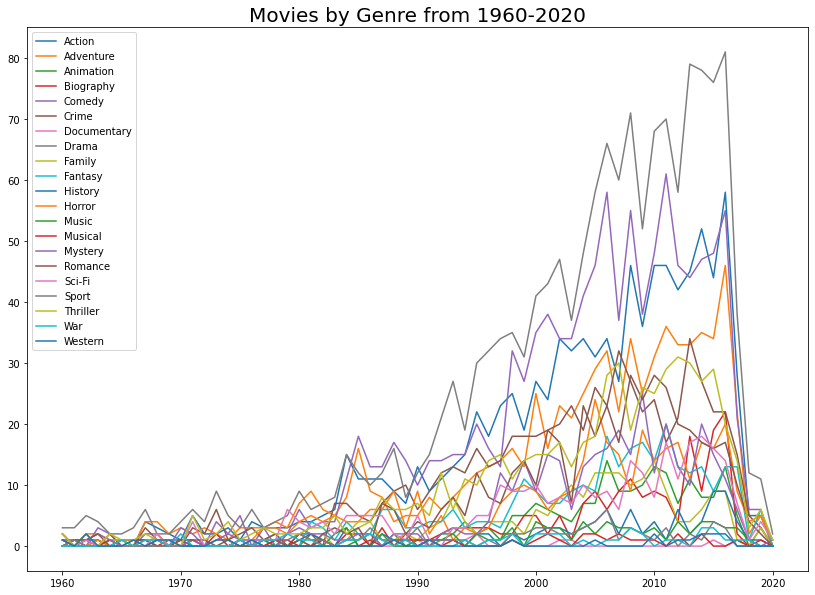

In [641]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(14,10))
plt.plot(years_by_genre.T)
plt.title('Movies by Genre from 1960-2020',fontsize=20)
plt.xticks(range(1960,2030,10))
plt.legend(years_by_genre.T)
plt.show()

-----------------------------------
### Read in top 1000 budget data 

In [531]:
df_budget1 = pd.read_csv('data/regex_imdb.csv')
top50lst = df_budget1.sort_values(by='Gross', ascending=False).head(50)['Name']
top50lst = list(top50lst)
#top50lst

In [642]:
## top 50 list check
#df_budget1[df_budget1['Name'].isin(top50lst)].sort_values(by='Gross', ascending=False)

In [643]:
#df_budget1.sort_values(by='Rating',ascending=False)

## Create flags for plotting based on Good/Bad and Successful/Not Successful ROI  

## Add a flag in the DF for movie financial success.
#### Value is 1 if Revenue is 3X budget, 0 if not

In [701]:
bayes_df = df_alldata.copy()

In [702]:
# Create Success Column
s_conditions = [
    bayes_df['Revenue']>3*bayes_df['Budget'],
    bayes_df['Revenue']<3*bayes_df['Budget']
    ]
s_results = [1,0]
bayes_df['Success'] = np.select(s_conditions,s_results) 

In [703]:
## Add a column: 'Good' in the DF.
#### Value is 1 if aggregated score is >= 7, 0 if not

In [704]:
# Create Good Movie Column
s_conditions1 = [
    (bayes_df['Wins']>0),
    (bayes_df['Nominations']>0),
    bayes_df['Score']>=7.5,
    bayes_df['Score']<7.5,
    ]
s_results1 = [1,1,1,0]
bayes_df['Good'] = np.select(s_conditions1,s_results1,default=0) 

In [705]:
# convert ROI to whole number for easier graphing
bayes_df['ROI']=bayes_df['ROI'].astype((int))

In [706]:
bayes_df.to_csv(r'data/bayes_df.csv', index = False, header=True)

In [711]:
%store bayes_df

Stored 'bayes_df' (DataFrame)


## Data with Flags for Statistical Analysis

In [708]:
bayes_df.describe()

,Score,Budget,Revenue,ROI,Year,Runtime,Wins,Nominations,Decade,Success,Good
count,3396.00000,3396.000000,3396.000000,3.396000e+03,3396.000000,3396.000000,3396.000000,3396.000000,3396.000000,3396.000000,3396.000000
mean,6.32177,41.209953,126.833333,1.009727e+03,2003.083628,110.345995,0.220259,0.609541,1998.580683,0.402827,0.315371
std,1.23053,44.484040,191.100083,2.326623e+04,11.565403,19.389675,0.889349,1.497593,11.797992,0.490539,0.464732
min,1.77000,0.000000,0.000000,0.000000e+00,1960.000000,63.000000,0.000000,0.000000,1960.000000,0.000000,0.000000
25%,5.38000,11.000000,22.000000,1.130000e+02,1997.000000,97.000000,0.000000,0.000000,1990.000000,0.000000,0.000000
50%,6.40000,26.000000,60.000000,2.400000e+02,2006.000000,107.000000,0.000000,0.000000,2000.000000,0.000000,0.000000
75%,7.32000,55.000000,152.000000,4.600000e+02,2012.000000,120.000000,0.000000,0.000000,2010.000000,1.000000,1.000000
max,9.10000,380.000000,2787.000000,1.289038e+06,2020.000000,248.000000,11.000000,11.000000,2020.000000,1.000000,1.000000


In [709]:
bayes_df.head()

,Title,Score,Budget,Revenue,ROI,Year,Runtime,Genres,Wins,Nominations,Decade,Success,Good
0,The Shawshank Redemption,8.95,25,28,113,1994,142,Drama,0,7,1990,0,1
1,The Godfather,9.10,6,245,4084,1972,175,"Crime,Drama",3,8,1970,1,1
2,Schindler's List,8.95,22,321,1460,1993,195,"Biography,Drama,History",7,5,1990,1,1
3,Parasite,5.68,11,245,2164,2019,133,"Horror,Sci-Fi",4,2,2010,1,1
4,Spirited Away,8.82,19,274,1446,2001,125,"Adventure,Animation,Family",0,0,2000,1,1


In [710]:
#bayes_df[bayes_df['Score']<7.5].sort_values(by='Score',ascending=False)

,Title,Score,Budget,Revenue,ROI,Year,Runtime,Genres,Wins,Nominations,Decade,Success,Good
1041,The Simpsons Movie,7.48,75,527,702,2007,87,"Adventure,Animation,Comedy",0,0,2000,1,0
1114,Safety Not Guaranteed,7.48,0,4,589,2012,85,"Comedy,Drama,Romance",0,0,2010,1,0
374,Frida,7.48,12,56,469,2002,123,"Biography,Drama,Romance",2,4,2000,1,1
984,Shame,7.48,6,19,294,2011,102,Drama,0,0,2010,1,0
988,The Lobster,7.48,4,15,391,2015,118,"Comedy,Drama,Romance",0,0,2010,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3391,Alone in the Dark,2.22,20,10,52,2005,96,"Action,Horror,Sci-Fi",0,0,2000,0,0
3388,Baby Geniuses,2.20,12,36,303,1999,97,"Comedy,Crime,Family",0,0,1990,0,0
3393,Battlefield Earth,2.15,44,21,48,2000,118,"Action,Adventure,Sci-Fi",0,0,2000,0,0
3392,Disaster Movie,2.05,25,14,56,2008,87,"Comedy,Sci-Fi",0,0,2000,0,0


## Normalization of review scores

In [670]:
dfnorm = pd.read_csv('data/to_normalize.csv')
#dfnorm.columns
dfnorm1 = dfnorm[['audience_rating','Rating_average','tomatometer_rating','Vote Average']]

# NOTES:
#        IMDB = 'audience_rating'
#        Movielens = 'Rating_average'
#        Rotten Tomatoes = 'tomatometer_rating'
#        TMDB = 'Vote Average'
#        Box Office Mojo = Budget, Revenue

In [671]:
# copy the data
df_max_scaled = dfnorm.copy()

columns = ['audience_rating','Rating_average','tomatometer_rating','Vote Average']
# apply normalization techniques
for column in columns:
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
      
# view normalized data
#display(df_max_scaled)

,Title,Original_Title,Rating_average,tomatometer_rating,audience_rating,Budget,Revenue,Release_Date,TMDb_Id,IMDb_Id,Genres,Runtime,Popularity,Vote Count,Titile,Vote Average,Overview,Release Date
0,The Shawshank Redemption,The Shawshank Redemption,1.000000,0.91,0.98,25000000,28341469,1994-09-23,278,tt0111161,Crime | Drama,142.0,54.549,15551.0,The Shawshank Redemption,1.000000,Framed in the 1940s for the double murder of h...,1994-09-23
1,The Godfather,The Godfather,1.000000,0.98,0.98,6000000,245066411,1972-03-14,238,tt0068646,Crime | Drama,175.0,43.202,11795.0,The Godfather,1.000000,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14
2,Schindler's List,Schindler's List,0.988506,0.97,0.97,22000000,321365567,1993-11-30,424,tt0108052,Drama | History | War,195.0,31.658,9385.0,Schindler's List,0.988506,The true story of how businessman Oskar Schind...,1993-11-30
3,Parasite,기생충,0.977011,0.18,0.14,11363000,245924070,2019-05-30,496243,tt6751668,Comedy | Drama | Thriller,133.0,100.558,6106.0,Parasite,0.977011,"All unemployed, Ki-taek's family takes peculia...",2019-05-30
4,Spirited Away,千と千尋の神隠し,0.977011,0.97,0.96,19000000,274925095,2001-07-20,129,tt0245429,Animation | Fantasy | Family,125.0,41.760,9029.0,Spirited Away,0.977011,"A young girl, Chihiro, becomes trapped in a st...",2001-07-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5188,Alone in the Dark,Alone in the Dark,0.367816,0.01,0.11,20000000,10442808,2005-01-28,12142,tt0369226,Action | Fantasy | Horror | Thriller,96.0,9.452,337.0,Alone in the Dark,0.367816,Edward Carnby is a private investigator specia...,2005-01-28
5189,Disaster Movie,Disaster Movie,0.356322,0.01,0.21,25000000,14109284,2008-08-29,13805,tt1213644,Action | Comedy,87.0,12.038,597.0,Disaster Movie,0.356322,"The filmmaking team behind the hits ""Scary Mov...",2008-08-29
5190,Battlefield Earth,Battlefield Earth,0.333333,0.03,0.12,44000000,21400000,2000-05-10,5491,tt0185183,Action | Science Fiction | War,118.0,9.663,463.0,Battlefield Earth,0.333333,"In the year 3000, man is no match for the Psyc...",2000-05-10
5191,House of the Dead,House of the Dead,0.333333,0.03,0.10,7000000,13818181,2003-04-11,11059,tt0317676,Action | Horror | Thriller,90.0,NaN,NaN,NaN,NaN,NaN,NaN


-----------------
## Statistical Tests
----------------

In [683]:
### Removing outlier data ()

In [712]:
bayes_adj = bayes_df[bayes_df['ROI']<600]
bayes_adj['Score']=bayes_adj['Score']//1
bayes_adj.to_csv('bayes_adj', index = False, header=True)

Stored 'bayes_adj' (DataFrame)


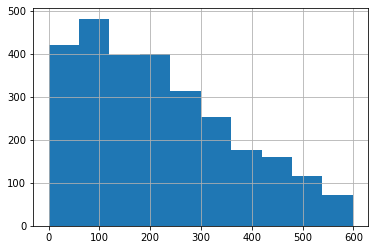

In [718]:
bayes_stat = bayes_adj.copy()

#bayes_stat['ROI'] = (bayes_stat['Revenue'].astype(float) / bayes_stat['Budget'].astype(float)) * 100
bayes_stat1= bayes_stat['ROI']
bayes_stat1.hist()
%store bayes_adj

### D'Agostino and Pearson's Test

In [714]:
# D'Agostino and Pearson's Test on ROI

from scipy.stats import normaltest
# generate univariate observations
datax = bayes_stat1
# normality test
stat, p = normaltest(datax)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=200.545, p=0.000
Sample does not look Gaussian (reject H0)


### Pearson's Correlation test

In [715]:
# Pearson's Correlation test
from scipy.stats import pearsonr
data1 = bayes_stat['Score']
data2 = bayes_stat['Revenue']
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.105, p=0.000
Probably dependent


### Shapiro-Wilk Test to determine if stats are Gaussian

In [716]:
# Shapiro-Wilk Test to determine if 'Score' distribution is Gaussian
from scipy.stats import shapiro


# generate univariate observations
data_s = bayes_stat['Score']
# normality test
stat, p = shapiro(data_s)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.935, p=0.000
Sample does not look Gaussian (reject H0)


In [717]:
# Shapiro-Wilk Test to determine if stats are Gaussian

from scipy.stats import shapiro


# generate univariate observations
data = bayes_stat['Revenue']
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.631, p=0.000
Sample does not look Gaussian (reject H0)


--------------------- 
FIN

---------------